In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [6]:
x.shape

torch.Size([1, 4, 512])

In [8]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [9]:
qkv = qkv_layer(x)

In [11]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0, 0.5, 'Frequency')

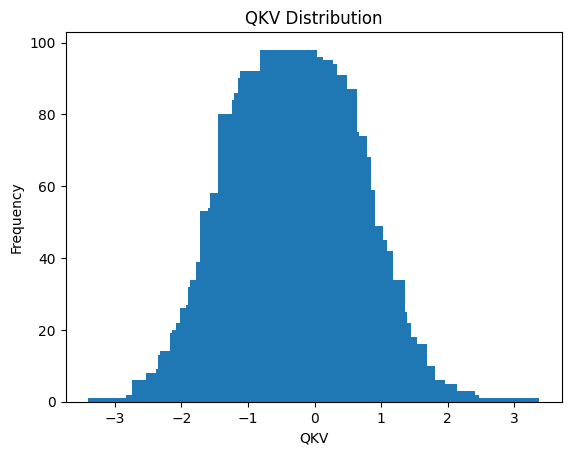

In [12]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min = 3, max = 3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align = "center")
plt.title("QKV Distribution")
plt.xlabel("QKV")
plt.ylabel("Frequency")

In [14]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [16]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [17]:
qkv = qkv.permute(0, 2, 1, 3) # Batch_size, Num_heads, Seq_len, 3 * head_dim
qkv.shape

torch.Size([1, 8, 4, 192])

In [18]:
q, k, v = qkv.chunk(3, dim = -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## **Self-Attention for Multiple Heads**

In [22]:
d_k = q.size()[-1]

In [23]:
d_k

64

In [28]:
import math
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [31]:
mask = torch.full(scaled.size(), float("-inf"))
mask = torch.triu(mask, diagonal = 1)

In [37]:
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [43]:
(scaled + mask)[0][0]

tensor([[-0.5725,    -inf,    -inf,    -inf],
        [-0.0828, -0.3109,    -inf,    -inf],
        [-0.3079,  0.1879, -0.1476,    -inf],
        [ 0.1030,  0.1079,  0.0370, -0.5750]], grad_fn=<SelectBackward0>)

In [44]:
scaled += mask

In [45]:
attention = F.softmax(scaled, dim = -1)

In [46]:
attention.shape

torch.Size([1, 8, 4, 4])

In [48]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5568, 0.4432, 0.0000, 0.0000],
        [0.2621, 0.4303, 0.3076, 0.0000],
        [0.2900, 0.2914, 0.2714, 0.1472]], grad_fn=<SelectBackward0>)

In [50]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [51]:
def scaled_dot_product_attention(q, k, v, mask = None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None:
    scaled += mask
  attention = F.softmax(scaled, dim = -1)
  values = torch.matmul(attention, v)
  return values, attention

In [52]:
values, attention = scaled_dot_product_attention(q, k, v, mask = None)

In [54]:
attention.shape

torch.Size([1, 8, 4, 4])

In [55]:
attention[0][0]

tensor([[0.1825, 0.2946, 0.3436, 0.1793],
        [0.2928, 0.2331, 0.2444, 0.2297],
        [0.2020, 0.3316, 0.2371, 0.2292],
        [0.2900, 0.2914, 0.2714, 0.1472]], grad_fn=<SelectBackward0>)

In [56]:
values, attention = scaled_dot_product_attention(q, k, v, mask = mask)

In [57]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5568, 0.4432, 0.0000, 0.0000],
        [0.2621, 0.4303, 0.3076, 0.0000],
        [0.2900, 0.2914, 0.2714, 0.1472]], grad_fn=<SelectBackward0>)

In [58]:
values.size()

torch.Size([1, 8, 4, 64])

In [61]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [62]:
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)

In [63]:
out.shape

torch.Size([1, 4, 512])

## **Multi-Head-Attention**

In [68]:
def scaled_dot_product(q, k, v, mask = None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None:
    scaled += mask
  attention = F.softmax(scaled, dim = -1)
  out = torch.matmul(attention, v)
  return out, attention

class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, num_heads):
    super().__init__()
    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
    self.linear_layer = nn.Linear(d_model, d_model)

  def forward(self, x, mask = None):
    batch_size, sequence_length, input_dim = x.size()
    print(f"x size: {x.size()}")
    qkv = self.qkv_layer(x)
    print(f"qkv size: {qkv.size()}")
    qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
    print(f"qkv size: {qkv.size()}")
    qkv = qkv.permute(0, 2, 1, 3)
    print(f"qkv size: {qkv.size()}")
    q, k, v = qkv.chunk(3, dim = -1)
    print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
    values, attention = scaled_dot_product(q, k, v, mask)
    print(f"values size: {values.size()}, attention size: {attention.size()}")
    values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
    print(f"values size: {values.size()}")
    out = self.linear_layer(values)
    print(f"out size: {out.size()}")
    return out

## **Input**

In [70]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x size: torch.Size([30, 5, 1024])
qkv size: torch.Size([30, 5, 1536])
qkv size: torch.Size([30, 5, 8, 192])
qkv size: torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values size: torch.Size([30, 8, 5, 64]), attention size: torch.Size([30, 8, 5, 5])
values size: torch.Size([30, 5, 512])
out size: torch.Size([30, 5, 512])
